<ipython-input-10-51aecee103ec>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
<ipython-input-10-51aecee103ec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['timestamp'].dt.hour
<ipython-input-10-51aecee103ec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['tim

Missing values per column:
 sensor_name            0
stream_temperature     0
timestamp              0
flow                   0
flow_temp              0
flowTimeIndex_delta    0
rowid                  0
Property               0
hour                   0
weekday                0
date                   0
dtype: int64
Average time gap between records (sec): 30.563230605738575


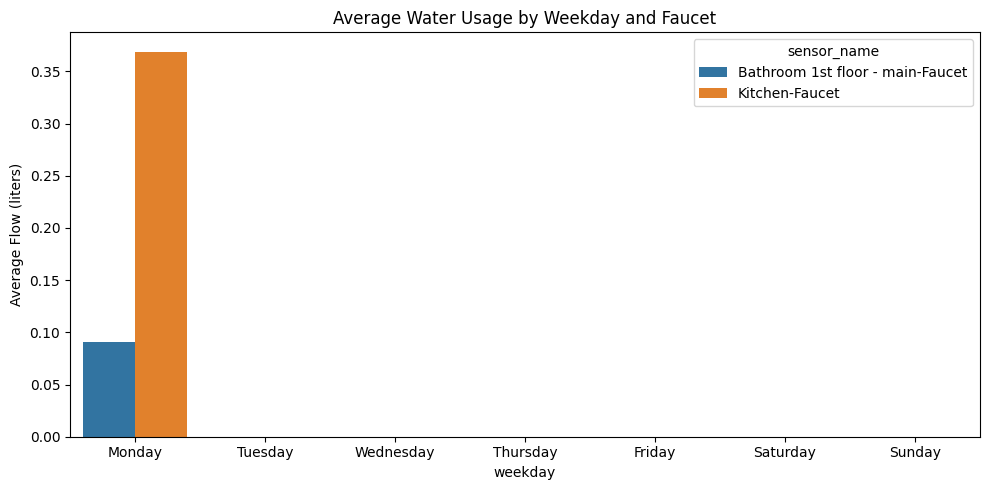

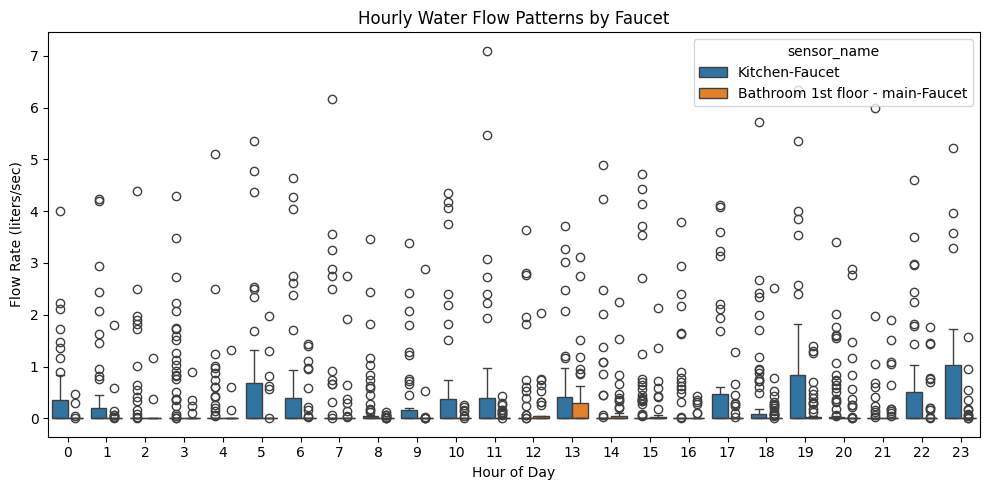


Average usage per session:
                                  total_flow  session_duration
sensor_name                                                   
Bathroom 1st floor - main-Faucet    1.461526        552.076923
Kitchen-Faucet                     10.711704       1187.888889


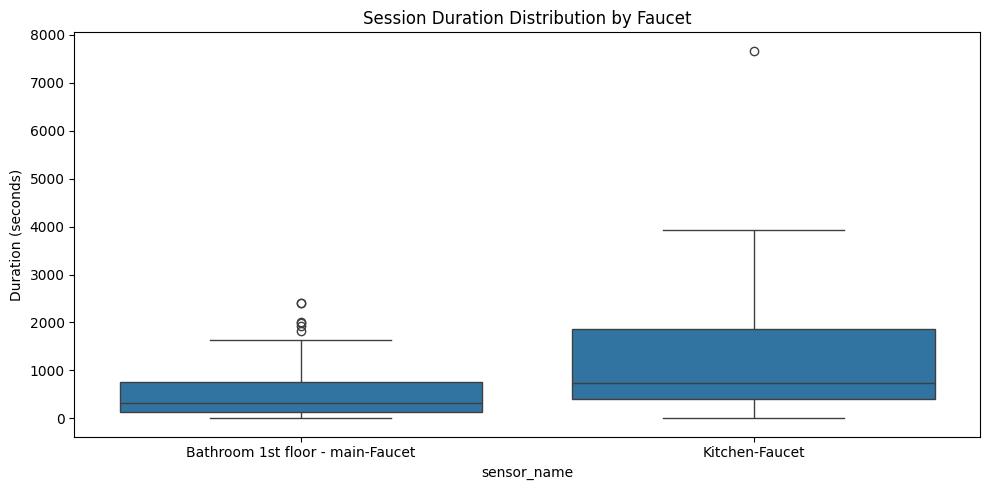

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("/content/dataset4 new.csv")

# Convert timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

# Rename flow column
df.rename(columns={'flow_quantity': 'flow'}, inplace=True)

# ------------------------------
# Check for missing values/gaps
# ------------------------------
print("Missing values per column:\n", df.isnull().sum())
df = df.sort_values('timestamp')
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
print("Average time gap between records (sec):", df['time_diff'].mean())

# ------------------------------
# 1.Weekly Usage Plots
# ------------------------------


# Weekly usage
weekly_usage = df.groupby(['weekday', 'sensor_name'])['flow'].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_usage['weekday'] = pd.Categorical(weekly_usage['weekday'], categories=weekday_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=weekly_usage, x='weekday', y='flow', hue='sensor_name')
plt.title('Average Water Usage by Weekday and Faucet')
plt.ylabel('Average Flow (liters)')
plt.tight_layout()
plt.show()

# ------------------------------
# 2. Peak Usage Times
# ------------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='hour', y='flow', hue='sensor_name')
plt.title('Hourly Water Flow Patterns by Faucet')
plt.xlabel('Hour of Day')
plt.ylabel('Flow Rate (liters/sec)')
plt.tight_layout()
plt.show()

# ------------------------------
# 3. Session Analysis
# ------------------------------
df['time_diff'] = df.groupby('sensor_name')['timestamp'].diff().dt.total_seconds()
df['new_session'] = df['time_diff'] > 300  # >5 minutes gap = new session
df['session_id'] = df.groupby('sensor_name')['new_session'].cumsum()

# Aggregate sessions
sessions = df.groupby(['sensor_name', 'session_id']).agg(
    session_start=('timestamp', 'min'),
    session_end=('timestamp', 'max'),
    total_flow=('flow', 'sum'),
    session_duration=('timestamp', lambda x: (x.max() - x.min()).total_seconds())
).reset_index()

# Session summary
session_summary = sessions.groupby('sensor_name')[['total_flow', 'session_duration']].mean()
print("\nAverage usage per session:")
print(session_summary)

# ------------------------------
# 4. Visualize Session Durations
# ------------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=sessions, x='sensor_name', y='session_duration')
plt.title('Session Duration Distribution by Faucet')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()
